# Compute image labels

## import libraries

In [1]:
#IMPORT MODULES
from context import geomapi 
# import geomapi


In [2]:
from geomapi.nodes import *
from geomapi.utils import geometryutils as gmu
from geomapi.tools import progresstools as pt
from geomapi.utils import imageutils as iu

from geomapi import utils as ut
from geomapi import tools as tl
import numpy as np
import open3d as o3d
import os
import cv2
import laspy
import copy
from matplotlib import pyplot as plt


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# input

In [3]:
week=21
cloudtype='sfm'
path=f'L:/Projects/2023-09 Benchmark construction site/Week {week}/'

#pcd
las_path= os.path.join(path,f'PCD/pcd-{cloudtype}/week{week}_{cloudtype}_labels (subsampled).las')
json_path= os.path.join(path,f'PCD/pcd-{cloudtype}/week{week}_sfm.json')
json_classes_path='L:/Projects/2023-09 Benchmark construction site/_classes.json'
subsample_percentage=0.1

#images
img_folder=os.path.join(path,'IMG_undistorted')
skip=2

#detections
mask_folder_segmentation=os.path.join(path,'IMG_segmentation_masks')
os.mkdir(mask_folder_segmentation) if os.path.exists(mask_folder_segmentation) is False else None
mask_folder_objects=os.path.join(path,'IMG_object_masks')
os.mkdir(mask_folder_objects) if os.path.exists(mask_folder_objects) is False else None
count_threshold=20000
range_threshold=None #not used
border_tolerance=300
octree_level=12 #lower this in the case of small regions or few points (12 is good for circa 50M points)

#temp files for restitution
excludeList=[100,255,61,3,63,60,62,64,53,55]
mask_folder_img=os.path.join(path,'IMG_undistorted2')
os.mkdir(mask_folder_img) if os.path.exists(mask_folder_img) is False else None
label_file=os.path.join(mask_folder_img, f'week{week}_annotations.json')

## import point clouds

In [4]:
# # if 'las' not in locals():
# las  = laspy.read(las_path)

# #reduce las file 
# # las=gmu.las_subsample(las,percentage=subsample_percentage)

# pcdNode=PointCloudNode(name=ut.get_filename(las_path),
#                         lasPath=las_path,
#                         resource=gmu.las_to_pcd(las)
#                         )

## import images

In [5]:
#get list of files
files=[f for f in ut.get_list_of_files(img_folder) if f.endswith('.xmp')]

#select every fifth files
imgNodes=[]
for f in files[0::skip]:     
    n=ImageNode(name=ut.get_filename(f),  #! this took quite long from remote drive                            
                                xmpPath=f,getResource=True)
    del n.resource
    if getattr(n,'imageWidth',None) is not None:
    #delete resource
    

        #set focallength and cartesianTransform
        n.focalLength35mm=n.focalLength35mm/36*n.imageWidth #! multiple definitions possible    
        rotation= n.cartesianTransform[0:3,0:3].T #! RC uses column-based rotaton matrix
        translation=n.cartesianTransform[0:3,3]
        n.cartesianTransform=gmu.get_cartesian_transform(rotation=rotation,translation=translation)
        
        imgNodes.append(n)
    
number=len(imgNodes)
imgNodes=[n for n in imgNodes if all(n.cartesianTransform[0:3,3] !=0)]
joinedImages=gmu.join_geometries([gmu.generate_visual_cone_from_image(n.cartesianTransform, height =1).paint_uniform_color([1,0,0]) for n in imgNodes])
print(f"{len(imgNodes)} / {number} Nodes created (remainder is not properly localised)!")

68 / 92 Nodes created (remainder is not properly localised)!


In [6]:
{key:value for key, value in n.__dict__.items() if not key.startswith('__') and not callable(key)}              

{'_xmlPath': None,
 '_xmpPath': 'L:/Projects/2023-09 Benchmark construction site/Week 21/IMG_undistorted/IMG_8084.xmp',
 '_orientedBoundingBox': None,
 'imageWidth': None,
 'imageHeight': None,
 'focalLength35mm': None,
 'keypoints': None,
 'descriptors': None,
 '_subject': rdflib.term.URIRef('file:///IMG_8084'),
 '_graph': None,
 '_graphPath': None,
 '_path': None,
 '_name': 'IMG_8084',
 '_timestamp': None,
 '_resource': None,
 '_cartesianTransform': None}

In [6]:
#build json data
from datetime import datetime
now = datetime.now()

for i,n in enumerate(imgNodes):
    n.json={
            "id": i,
            "license": 1, #! check whether license is ok?
            "file_name": n.name+'.JPG',
            "height": n.imageHeight,
            "width": n.imageWidth,
            "date_captured": now.strftime("%Y-%m-%dT%H:%M:%S%z")
            }

In [7]:
# show an image
# plt.imshow(iu.image_resize(imgNodes[11].resource,scale=0.1))

In [8]:
# show some rays
# rays=np.zeros((1,6))
# for n in imgNodes[0::20]:
#     # example uv points (top left, middle and bottom right)
#     uvCoordinates=np.array([[0,0], # top left
#                             [0,n.imageWidth], # top right
#                             # [np.floor(n.imageHeight/2),np.floor(n.imageWidth/2)], #middle
#                             [n.imageHeight,0], # bottom left
#                             [n.imageHeight,n.imageWidth] # bottom right
#                             ])
#     # transform uvcoordinates  to world coordinates to rays   
#     # n.rays=n.create_rays(uvCoordinates) 
#     rays=np.vstack((rays,n.create_rays(uvCoordinates)))
# rays=np.delete(rays,0,axis=0) 
# line_set=gmu.rays_to_lineset(rays,20)
# o3d.visualization.draw_geometries([line_set]+[joinedImages]+[pcdNode.resource])

In [9]:
# show some geometries
# joinedImages=gmu.join_geometries(meshes)
# joinedImages=joinedImages.paint_uniform_color([1,0,0])
# o3d.visualization.draw_geometries([joinedImages]+[pcdNode.resource])

## import objects


In [10]:
import json

# Read the JSON file
with open(json_path, 'r') as file:
    json_data = json.load(file)

# Create a dictionary
class_objects = json_data['objects']

for i,t in enumerate(class_objects):
    t['color']=ut.random_color(255) 
    t['color_label']=(t['color'][0] << 16) + (t['color'][1] << 8) + t['color'][2]

print(f'{len(class_objects)} objects found.')

601 objects found.


In [11]:
class_objects[-1]

{'name': '004_206_Walls_aggregates',
 'class_id': 4,
 'material_id': 26,
 'object_id': 601,
 'ifc_id': 255,
 'status_id': 255,
 'centroid': {'x': 44.74041797744511,
  'y': 80.84284190498698,
  'z': 4.685521762842194},
 'dimensions': {'length': 7.725394320994875,
  'width': 4.66781167478853,
  'height': 3.0196457},
 'rotations': {'x': 0, 'y': 0, 'z': 89.99999999999996},
 'color': array([ 89, 102, 104]),
 'color_label': 5858920}

In [12]:
# set noise, unreferenced objects and landscaping objects to zero
# obj=next(c for c in class_objects if (c['class_id']==100 or #noise
#                                       c['class_id']==255 or #undefined
#                                       c['class_id']==61 or #landscaping
#                                       c['class_id']==3 or #floors 
#                                       c['class_id']==63)) #ground
# obj['color']=np.array([0,0,0])
# obj['color_label']=0

## import classes


In [13]:
# Read the JSON file
with open(json_classes_path, 'r') as file:
    json_data = json.load(file)

# Create a dictionary
classes = json_data['classes']
print(classes)

class_jsons=[]
for n in classes:
    class_jsons.append({
            "id": n['id'],
            "name": n['name'],
            "supercategory": n['main_class']
            })

[{'name': 'Unassigned', 'id': 255, 'temp_id': -1, 'color': '#9da2ab', 'main_class': 'Unassigned'}, {'name': 'Structural_elements', 'id': 0, 'temp_id': 0, 'color': '#03c2fc', 'main_class': 'Structural_elements'}, {'name': 'Columns', 'id': 1, 'temp_id': 1, 'color': '#e81416', 'main_class': 'Structural_elements', 'ifc_class': 'IfcColumn'}, {'name': 'Beams', 'id': 2, 'temp_id': 2, 'color': '#ffa500', 'main_class': 'Structural_elements', 'ifc_class': 'IfcBeam'}, {'name': 'Floors', 'id': 3, 'temp_id': 3, 'color': '#faeb36', 'main_class': 'Structural_elements', 'ifc_class': 'IfcSlab'}, {'name': 'Walls', 'id': 4, 'temp_id': 4, 'color': '#79c314', 'main_class': 'Structural_elements', 'ifc_class': 'IfcWall'}, {'name': 'Stairs', 'id': 5, 'temp_id': 5, 'color': '#4b369d', 'main_class': 'Structural_elements', 'ifc_class': 'IfcStair'}, {'name': 'Secondary_elements', 'id': 10, 'temp_id': 100, 'color': '#fc7fb1', 'main_class': 'Secondary_elements'}, {'name': 'Ceilings', 'id': 11, 'temp_id': 101, 'colo

# Annotate images based on point cloud

## Raycast imagery (optional)

In [14]:
# index=1
# fill_black=20
# im1,_=pt.project_pcd_to_rgbd_images(pcdNode.resource,imgNodes[index],depth_max=50,fill_black=fill_black)
# im1=(im1[0]*255).astype(np.uint8)
# im2,_=pt.project_pcd_to_rgbd_images(pcd,imgNodes[index],depth_max=50,fill_black=fill_black)#,
# im3,_=pt.project_meshes_to_rgbd_images(mesh, imgNodes[index])

In [15]:
# from matplotlib import pyplot as plt
# import math
# n=imgNodes[index]
# fig, axs = plt.subplots(2, 2,figsize=(30, 30))
# fig.set_facecolor("white")
# axs[0,0].imshow(iu.image_resize(n.resource,scale=1/10))
# axs[0,1].imshow(iu.image_resize(im1,scale=1/10))

# axs[1,0].imshow(iu.image_resize(im2[0],scale=1/10))
# axs[1,1].imshow(iu.image_resize(im3[0],scale=1/10))

# plt.show()

## Raycast scene

In [16]:
# if 'mesh' not in locals():
#colorize pcd by objects
labels=las['object_labels']
del las
#use black color for '0' == unassigned
colors=np.vstack((np.array([0,0,0]),np.array([c['color'] for c in class_objects])))

#convert pcd to mesh
pcd=copy.deepcopy(pcdNode.resource)
colorArray=gmu.array_to_colors(labels,colors)
pcd.colors=o3d.utility.Vector3dVector(colorArray)
octree=pt.pcd_to_octree(pcd,octree_level) #if octree is None else octree
del pcd
mesh=gmu.octree_to_voxelmesh(octree) #if mesh is None else mesh
del octree

MemoryError: bad allocation

In [ ]:
#! clear resources




In [ ]:
o3d.visualization.draw_geometries([joinedImages]+[mesh])

## Project imagery

In [ ]:
# index=1

In [ ]:
# projections,_=pt.project_meshes_to_rgbd_images(mesh, imgNodes) # no depth filtering currently

In [ ]:
# create scene
#create raytracing scene
scene = o3d.t.geometry.RaycastingScene()
reference=o3d.t.geometry.TriangleMesh.from_legacy(mesh)
scene.add_triangles(reference)

#create a colorArray from the mesh triangles (color of first vertex is taken)
colors=np.asarray(mesh.vertex_colors)
indices=np.asarray(mesh.triangles)[:,0]
triangle_colors=colors[indices]
#append black color at the end of the array for the invalid hits
triangle_colors=np.vstack((triangle_colors,np.array([0,0,0])))

In [ ]:
# for n in imgNodes:
#     del n.resource

In [ ]:
#create mapping dictionary

#define mapping
def remap_value(value, mapping_dict):
    return mapping_dict.get(value, value)

#create dictionary
object_dict = {}
segmentation_dict={}
for m in class_objects:
    object_dict[m['color_label']]=m['object_id']
    segmentation_dict[m['color_label']]=m['class_id']
        

In [ ]:
#create rays  
for n in imgNodes:
    #get resource
    n.get_resource()

    rays = o3d.t.geometry.RaycastingScene.create_rays_pinhole(
                                    intrinsic_matrix =n.get_intrinsic_camera_parameters().intrinsic_matrix,
                                    extrinsic_matrix =np.linalg.inv(n.get_cartesian_transform()),
                                    width_px=int(n.imageWidth),
                                    height_px=int(n.imageHeight))
    ans = scene.cast_rays(rays) 
    
    #get triangle_ids that are hit per ray
    triangle_ids=ans['primitive_ids'].numpy() # triangles
    rows,columns=triangle_ids.shape        
    triangle_ids=triangle_ids.flatten()
    # replace invalid id's by last (which is the above added black color)
    np.put(triangle_ids,np.where(triangle_ids==scene.INVALID_ID),triangle_colors.shape[0]-1) 
    
    #select colors 
    colors=triangle_colors[triangle_ids]

    #reshape array back to normal
    # projections.append(np.reshape(colors,(rows,columns,3)))
    im=colors
    
    # Create row and column indices using numpy meshgrid
    rows, cols = np.meshgrid(np.arange(n.imageHeight), np.arange(n.imageWidth), indexing='ij')
    result = np.stack((rows, cols), axis=-1)
    result=np.reshape(result,(-1,2))
    
    #convert colors to color_labels
    pixel_colors=(im*255).astype(np.uint32)
    pixel_colors = (pixel_colors[:, 0] << 16) + (pixel_colors[:, 1] << 8) + pixel_colors[:, 2]

    #get unique values
    unique_colors,counts=np.unique(pixel_colors,return_counts=True)  #indices are in flattened array

    #test if not all 0
    if unique_colors.size!=1 or unique_colors[0]!=0:

        # select relevant groups of pixels
        detections=[]
        for u,c in zip(unique_colors, counts):  
            # n.temp=pixel_colors     
            if c > count_threshold and c!=0:
                #match id
                class_object=next((t for t in class_objects if t.get('color_label') ==u ),None)
                if class_object:
                    #get pixel_values
                    ind=np.where(pixel_colors==u)[0]
                    imageCoordinates=result[ind,:]
                    
                    #compute region (bbox)               
                    rowmin=int(imageCoordinates[:,0].min())
                    rowmax=int(imageCoordinates[:,0].max())
                    
                    columnmin=int(imageCoordinates[:,1].min())
                    columnmax=int(imageCoordinates[:,1].max())
                    
                    width=columnmax-columnmin
                    height= rowmax-rowmin          
                    
                    segmentation=[columnmin,rowmin,
                                columnmax,rowmin, 
                                columnmax,rowmax,
                                columnmin,rowmax]

                    #compute center
                    centerCol=np.average([columnmin,columnmax])
                    centerRow=np.average([rowmin,rowmax])

                    #avoid detections near edge
                    if not all(np.isclose(centerCol,[0,n.imageWidth],atol=border_tolerance)) and not all(np.isclose(centerRow,[0,n.imageHeight],atol=border_tolerance)):

                        #compute detection
                        obj = {
                                "id": class_object['object_id'], #object id?
                                "name": class_object['name'],
                                "image_id": n.json['id'],
                                "category_id": class_object['class_id'], #class_id
                                "material_id":class_object['material_id'],
                                "object_id":class_object['object_id'],
                                "ifc_id":class_object['ifc_id'],
                                "status_id":class_object['status_id'],
                                "bbox": [columnmin,rowmin, width,height], #xmin,ymin, width, height
                                "area": width*height,
                                "segmentation": segmentation,
                                "iscrowd": 0
                            }
                    
                        detections.append(obj)
        n.detections=detections

        #map numbers
        mask_object = np.reshape(np.vectorize(remap_value)(pixel_colors, object_dict),(n.imageHeight,n.imageWidth))
        mask_segmentation=  np.reshape(np.vectorize(remap_value)(pixel_colors, segmentation_dict),(n.imageHeight,n.imageWidth))

        #write to file
        cv2.imwrite(os.path.join(mask_folder_img,n.name+'.JPG'),n.resource)
        np.save(os.path.join(mask_folder_segmentation,n.name),mask_segmentation)
        np.save(os.path.join(mask_folder_objects,n.name),mask_object)

        #delete image
        del n.resource
    print(f'{n.name}        :{len(detections)} detections')
    

IMG_6315        :24 detections
IMG_6470        :19 detections
IMG_6522        :24 detections
IMG_6572        :31 detections
IMG_6688        :19 detections
IMG_7207        :38 detections
IMG_7312        :29 detections
IMG_7412        :36 detections
IMG_7513        :34 detections
IMG_7566        :26 detections
IMG_7687        :9 detections
IMG_7742        :26 detections
IMG_7799        :11 detections
IMG_7955        :22 detections
IMG_8007        :14 detections
IMG_8070        :56 detections


## Compute labels

## plot results

In [ ]:
#plot 1 result
# import matplotlib.pyplot as plt
# import matplotlib.patches as patches
# #select detection
# obj=detections[-1]
# # copy image
# image = copy.deepcopy(projections[-1])
# fig, ax = plt.subplots(1)

# #mark pixels
# pixels_to_mark=np.reshape(np.array(obj['segmentation']),(-1,2))
# for pixel in pixels_to_mark:
#     x, y = pixel
#     image[y,x,:]=np.array([1,0,0])
# #mark box
# rect = patches.Rectangle((obj['bbox'][0], obj['bbox'][1]), obj['bbox'][2], obj['bbox'][3], linewidth=1, edgecolor='r', facecolor='none')
# ax.add_patch(rect)
# ax.imshow(image)

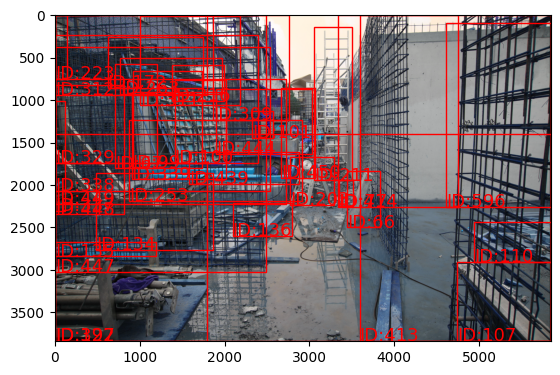

In [ ]:
#mark all boxes
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

n=imgNodes[random.randint(0,len(imgNodes))]

# boxes=[d['bbox'] for d in detections]

fig, ax = plt.subplots(1)
ax.imshow(n.get_resource())

# Plot each rectangle on the image
for d in n.detections:
    rect = patches.Rectangle((d['bbox'][0], d['bbox'][1]), d['bbox'][2], d['bbox'][3], linewidth=1, edgecolor='r', facecolor='none') # xy, width, height
    ax.add_patch(rect)
    rectangle_name = 'ID:'+str(d['id'])
    ax.text(d['bbox'][0], d['bbox'][1]+d['bbox'][3], rectangle_name, fontsize=13, color='r')
plt.show()

In [ ]:
# compute alpha shape
# from alphashape import alphashape
# alphashape([point.coords[0] for point in gdf['geometry'][0]], 0.7).show()


# export results

## image mask

In [ ]:
# #define mapping
# def remap_value(value, mapping_dict):
#     return mapping_dict.get(value, value)

# #create dictionary
# object_dict = {}
# segmentation_dict={}
# for m in class_objects:
#     object_dict[m['color_label']]=m['object_id']
#     segmentation_dict[m['color_label']]=m['class_id']
    
# print(object_dict)
# #map numbers
# for n in imgNodes: #! 9s per mask
#     # Use numpy.vectorize to apply the custom mapping function element-wise
#     n.mask_object = np.reshape(np.vectorize(remap_value)(n.temp, object_dict),(n.imageHeight,n.imageWidth))
#     n.mask_segmentation=  np.reshape(np.vectorize(remap_value)(n.temp, segmentation_dict),(n.imageHeight,n.imageWidth))
#     print(f'{n.name} mapped')

In [ ]:
# #export
# for n in imgNodes:
#     if getattr(n,'mask_segmentation',None) is not None:
#         os.mkdir(mask_folder_segmentation) if os.path.exists(mask_folder_segmentation) is False else None
#         cv2.imwrite(os.path.join(mask_folder_segmentation,n.name+'.JPG'),n.mask_segmentation)
#     if getattr(n,'mask_object',None) is not None:        
#         os.mkdir(mask_folder_objects) if os.path.exists(mask_folder_objects) is False else None
#         cv2.imwrite(os.path.join(mask_folder_objects,n.name+'.JPG'),n.mask_object)

In [ ]:
# #export temp
# for n in imgNodes:
#     if getattr(n,'mask_segmentation',None) is not None:
#         os.mkdir(img_folder_temp) if os.path.exists(img_folder_temp) is False else None
#         cv2.imwrite(os.path.join(img_folder_temp,n.name+'.JPG'),n.resource)

## json

In [ ]:
#json conform roboflow

# Create the JSON data as a Python dictionary
json_data = {
    "info": {
        "year": "2023",
        "version": "1",
        "description": "Exported from roboflow.ai",
        "contributor": "",
        "url": "https://public.roboflow.ai/object-detection/undefined",
        "date_created": "2023-07-31T09:53:03+00:00"
    },
    "licenses": [
        {
            "id": 1,
            "url": "https://creativecommons.org/licenses/by/4.0/",
            "name": "CC BY 4.0"
        }
    ]}

#map categories
json_data["categories"]=[c for c in class_jsons]
print(f'number of classes: {len([c for c in class_jsons])}')

#map images
json_data["images"]=[n.json for n in imgNodes]
print(f'number of images: {len(json_data["images"])}')

# #map annotations
nested_list=[n.detections for n in imgNodes if getattr(n,'detections',None) is not None]
flattened_list = [item for sublist in nested_list for item in (sublist if isinstance(sublist, list) else [sublist])]
cleaned_list= [f for f in flattened_list if f['category_id'] not in excludeList] #! this is temporary
json_data["annotations"]= cleaned_list
print(f'number of annotations: {len(json_data["annotations"])}')

# # Convert the dictionary to a JSON-formatted string
# json_string = json.dumps(json_data, indent=2)

number of classes: 45
number of images: 16
number of annotations: 326


In [ ]:
#write this information to the 3D detection json
with open(label_file, "w") as json_file:
    json.dump(json_data, json_file, indent=4)
print("JSON data written to file:", label_file)

JSON data written to file: L:/Projects/2023-09 Benchmark construction site/Week 21/IMG_undistorted2\week21_annotations.json
